# Temperature Forecast - Assignment 

In this assignment, you will apply the concepts learned in the  SARIMA model to forecast temperature. Temperature shows a highly seasonal pattern that repeats yearly. We believe that you'll analyze and apply similar methods in any seasonal data in the future after completing this assignment. 

<b><div style="text-align: right">[TOTAL POINTS: 8]</div></b>

### Learning Objective

- Explore and pre-process temperature time-series data

- Apply the ADF test to check the stationarity of the time series

- Apply seasonal difference on the data to reduce seasonality in the time series

- Evaluate different models fitted on the time series and choose one

## Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

from scipy import optimize
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tsa import stattools
from statsmodels.tsa.statespace import tools 
from statsmodels.tsa.arima_process import ArmaProcess


In [2]:

import statsmodels.api as sm


def plot_series(X, X_=None,
                figsize=(16, 6), title='Time Series Plot', x_label='Date', y_label='Value of X',
                forecast=False, season=None):
   
    """Plots the time series data X.

    Args:
        X (np.array): Time-series data
        X_ (np.array): Forecasted time-series data
        title (str) - Title for the figure
        y_label (str) - y-label for the figure
        figsize (tuple): Size of figure
        forecast (bool): if true appends predictions after observed data
        season (int): season

    """
    
    fig = plt.figure(figsize=figsize)

    if type(X) is np.ndarray:
        plt.plot(X, linewidth=2)
    else:
        X.plot(fontsize=13, linewidth=2)

    plt.title(title, fontsize=16)
    plt.xlabel(x_label, fontsize=14)
    plt.ylabel(y_label, fontsize=14)

    if season and type(X) is np.ndarray:
        plt.xticks(
            range(0, len(X) + 1 if not forecast else len(X) + len(X_) + 1, season),
            fontsize=13
        )

    if X_ is not None:
        if not forecast:
            plt.plot(X_, linewidth=2)
        else:
            plt.plot(range(len(X), len(X_) + len(X)), X_, linewidth=2)
        plt.legend(['True Values', 'Forecasted Values'], fontsize=14)

    plt.grid()
    plt.show()


def plot_graphs(X=None, lags=80, season=None):
    """ Plots ACF and PACF graphs
        
    Args:
        X (np.array): Time-series data
        lags (int): number of lags up to which ACF and PACF plots will be shown
        season (int): season  
    
    """
    
    fig = plt.figure(figsize=(10, 6))
    fig.subplots_adjust(hspace=0.5)

    ax1 = fig.add_subplot(211)

    sm.graphics.tsa.plot_acf(X, ax=ax1, lags=lags)
    plt.title('Autocorrelation', fontsize=15)
    if season:
        plt.xticks(range(0, lags + 1, season), fontsize=14)
    plt.grid()

    ax2 = fig.add_subplot(212)

    sm.graphics.tsa.plot_pacf(X, ax=ax2, lags=lags)
    plt.title('Partial Autocorrelation', fontsize=15)
    if season:
        plt.xticks(range(0, lags + 1, season), fontsize=14)
    plt.grid()
    plt.show()

## Dataset Description

You'll deal with a temperature dataset in this assignment. The dataset consists of the monthly average temperature of Massachusetts state of America from 1985 to 2019. The data can be collected from [here](https://www.ncdc.noaa.gov/cag/national/time-series). The data has been dumped to a csv file named `Temperature.csv` and is placed in `data` folder. It consists of three columns:

1. **Date**: The date column gives the year and month in which the corresponding row data was collected.

2. **Value**: This column consists of temperature in degree Fahrenheit. In this assignment, we'll use this column for forecasting future temperatures.

3. **Anomaly**: The anomaly column gives the deviation from the mean, relative to the month.

Let's read the csv file into a dataframe. The `Date` column consists of the year and month in string. We need to transform it into `Datetime` format. Then, we need to index the dataframe with `Date`. 

In [3]:
df = pd.read_csv('https://drive.google.com/uc?id=1Vj1t4vxUtyjBg9XMt6__YIgUfkLRotvD')
df.set_index('Date', inplace=True)
df.head()

,Value,Anomaly
Date,,
1895-01,22.4,-1.7
1895-02,18.5,-6.5
1895-03,30.8,-3.4
1895-04,43.7,-1.0
1895-05,57.7,2.0


The data has been loaded. Next, we'll plot the time series data. For this, we'll use the `plot_series` function, which we have defined earlier.

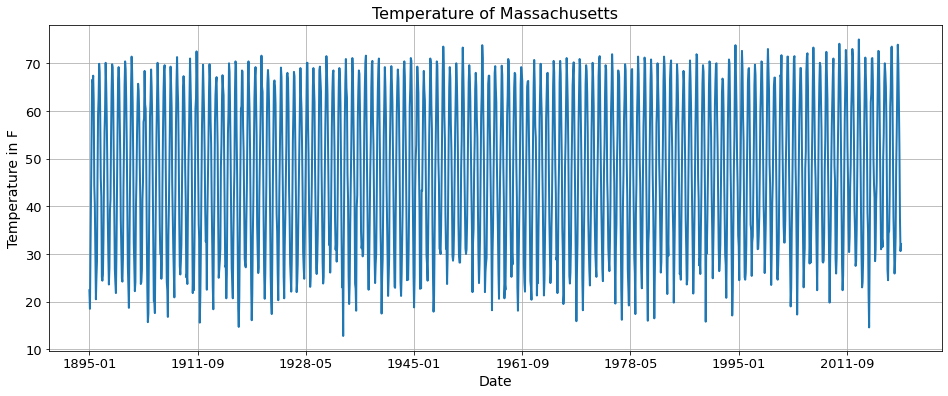

In [4]:
plot_series(df.Value, title='Temperature of Massachusetts', y_label='Temperature in F')
X = df.Value.values

On observing the above plot, the temperature ranges from about 20 degrees Fahrenheit to about 70 degrees Fahrenheit in the state over a year. Since Massachusetts lies to the north of America, the temperature is usually low there. 

Also, you may realize that there is a strong seasonality present in the data. This behavior is obvious due to the seasonal behavior of temperature (high in summer and low in winter), which repeats every year. Since it's a monthly data, it is intuitive to set the season equal to `12`. Let's validate the intuition. We can plot the temperature for 12 months for each year and see if the pattern exists. We can do this as follows.

[]

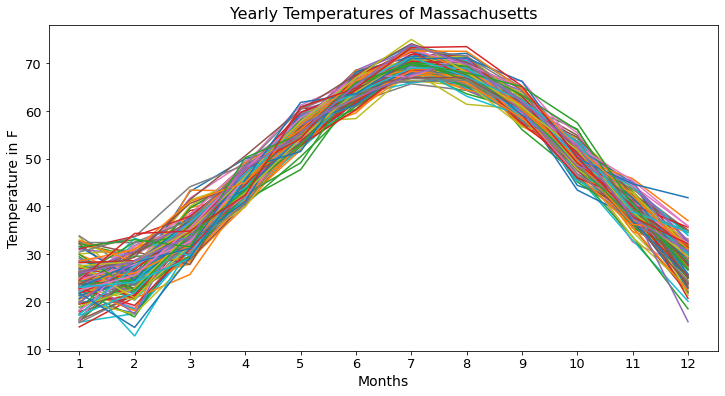

In [5]:
index = pd.DatetimeIndex(df.index) 
pivot = pd.pivot_table(df, values='Value', index=index.month, columns=index.year)

pivot.plot(figsize=(12, 6), fontsize=13)
plt.title('Yearly Temperatures of Massachusetts', fontsize=16)
plt.ylabel('Temperature in F', fontsize=14)
plt.xlabel('Months', fontsize=14)
plt.xticks(range(1, 13))
plt.legend().remove()
plt.plot()

Well, the overall pattern for a year seems to repeat over the years. Secondly, we can check the autocorrelations for the data. For seasonal data, the autocorrelations show seasonality too. Let's plot the ACF graph and see.

### Exercise 1: ACF Plot

**<div style="text-align: right"> [POINTS: 2]</div>**

**Task:**

* Use `statools.acf` function to get autocorrelation values up to lag 80 for data $X$ 

In [6]:
### Ex-1-Task-1

autocorrelations = None
### BEGIN SOLUTION
# your code here
autocorrelations = stattools.acf(X, nlags=80)
# raise NotImplementedError
### END SOLUTION

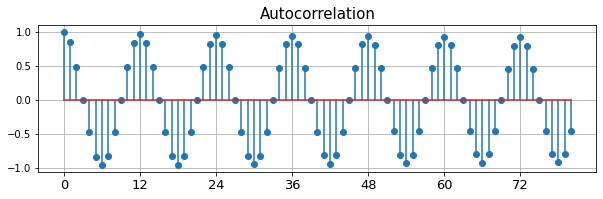

In [7]:
fig = plt.figure(figsize=(10, 2.7))
plt.stem(autocorrelations)
plt.title('Autocorrelation', fontsize=15)
plt.xticks(range(0, 80, 12), fontsize=13)
plt.grid()
plt.show()

**Expected nature of ACF graph**

We know that the temperature, today, will be close to the temperature on the same day a year ago or two years ago or so. Thus we should have high positive autocorrelations at lags equal to integer multiples of 1 year (12 in case of monthly data). On the other side, at lags equal to half-year, the temperature has the opposite trend. Let's take the example of winter and summer. On a certain day in winter, the temperature is very low, while the temperature after the exact six months will be high. Thus at lags equal to half-year (5 in case of monthly data), autocorrelations should have negative values. 

Next, we'll assign `season` equal to 12.

In [8]:
season = 12

## Stationarity Check

Let's check the stationarity in the data. You can use the ADF test as in the reading materials. 

#### Exercise 2: ADF Test

**<div style="text-align: right"> [POINTS: 2]</div>**

**Task:**

* Prepare a function `get_p_value` which returns the p_value obtained from the ADF test.   
[*Hint*: create a lambda function using `statools.adfuller`]

In [9]:
### Ex-2-Task-1
get_p_value = None
### BEGIN SOLUTION
# your code here
get_p_value=lambda x:stattools.adfuller(X)[1]
# raise NotImplementedError
### END SOLUTION

In [10]:
Z = np.random.randn(500)  # random values generated from normal distribution 
# assert get_p_value(Z) < 1e-30  #  ADF test must return very small p_value for random values

p_value = get_p_value(X)
print('p-value for the data, X = ', p_value)

p-value for the data, X =  0.001365366123009658


We usually use 0.05 as a threshold for the ADF test. The `p_value` for the data seems to be lower than the threshold. However, it's not that significantly less. We have observed that the `p_value` of the order of `1e-20` in the reading materials. The data doesn't seem to have a significant amount of trend. Thus, we won't do non-seasonal differences in the data. However, the data has a strong seasonality present. Let's try a seasonal differencing of order 1. 

### Exercise 3: Seasonal Differencing

**<div style="text-align: right"> [POINTS: 2]</div>**

**Task:**

* Operate first order seasonal differencing on the data X.   
[*Hint*: Use `tools.diff` function]

In [11]:
### Ex-3-Task-1
D_X = None
### BEGIN SOLUTION
# your code here
D_X=tools.diff(series=X,k_diff=0,k_seasonal_diff=1,seasonal_periods=season)
# raise NotImplementedError
### END SOLUTION

p-value for the differenced data, D_X =  0.001365366123009658


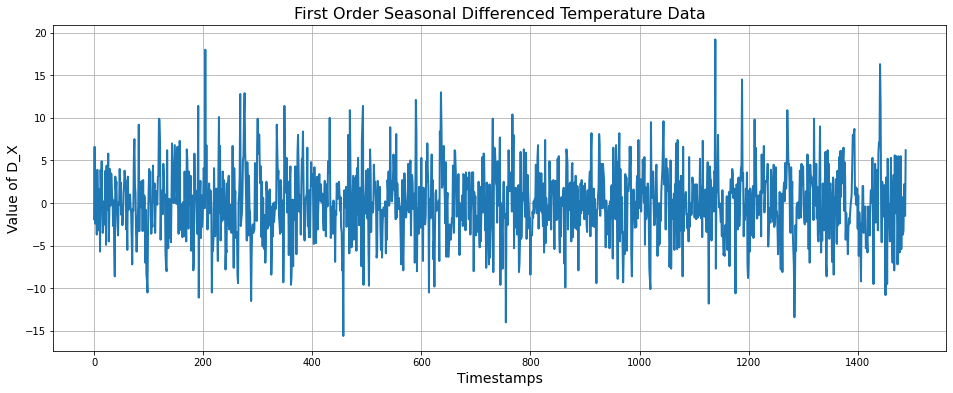

In [12]:
# assert len(D_X) == len(X) - season  # length of seasonal difference series must be equal to length of series - season

p_value = get_p_value(D_X)
print('p-value for the differenced data, D_X = ', p_value)

plot_series(
    D_X, 
    title='First Order Seasonal Differenced Temperature Data',
    x_label='Timestamps', y_label='Value of D_X'
)

If you observe the above plot, the seasonal differencing in the data seems to have reduced the seasonality. Also, the p-value is comparatively less. Let's proceed to estimate the orders for the AR and MA parts. Before that, we set the differencing orders (non-seasonal differencing - `d` and seasonal differencing - `D`) as follows, which summarizes our steps till now.

In [13]:
d = 0
D = 1

## Orders Estimation

Let's plot the autocorrelation and partial autocorrelation graphs for the differenced series `D_X`. 

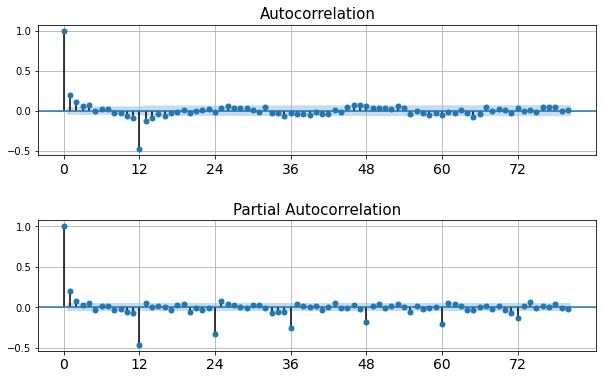

In [14]:
plot_graphs(D_X, season=season)

In [15]:
# Non-seasonal orders
p_ = (0, 2)
q_ = (0, 2)

# Seasonal orders
P_ = (0, 0)
Q_ = (1, 1)

## Model Selection

After having the rough estimates for the model's orders, we make brute force search over the ranges of orders to obtain the model with the evaluation score. We'll use the Bayesian Information Criterion (BIC) as the evaluation metric. We can use `optimize.brute` from `scipy`. Know that it will take a while for the brute force search. 

We've defined the following two functions:

1. `f`- minimization function that fits a SARIMA model of provided order on obtained data and returns the model's AIC score.

2. `min_order_search`- a search function that takes the ranges for the orders and does a brute force search for the minimum `f` value.

These above three functions are the ones as we defined in the reading materials. You may like to understand the working of these functions.

### Exercise 4: SARIMA Model

**<div style="text-align: right"> [POINTS: 2]</div>**

**Task:**

* Prepare a function `get_SARIMA_model` with arguments (X, p, d, q, P, D, Q, s). The function should return an instance of the SARIMA model. Say if some function `sarima` instantiates a SARIMA model, you can define `get_SARIMA_model` as:
```python
get_SARIMA_model = lambda X, p, d, q, P, D, Q, s: sarima(X, p, d, q, P, D, Q, s)
```
[*Hint*: create a lambda function using `sm.tsa.SARIMAX`.]

In [16]:
### Ex-4-Task-1
get_SARIMA_model = None

### BEGIN SOLUTION
# your code here
# def get_SARIMA_model(X, p, d, q, P, D, Q, s):
get_SARIMA_model = lambda X, p, d, q, P, D, Q, s: sm.tsa.SARIMAX(endog=X, order=(p, d, q), seasonal_order=(P, D, Q, s))
# raise NotImplementedError
### END SOLUTION

In [17]:
_X = np.random.randn(100)
_order = (1, 0, 2)
_seasonal_order = (3, 0, 4, 5)

_model = get_SARIMA_model(_X, *_order, *_seasonal_order)

assert _model.order == _order
assert _model.seasonal_order == _seasonal_order
assert (_model.endog.ravel() == _X).all()



In [18]:
def f(order, X, d, D, s):
    """ Minimization function
        It generates a SARIMA model with provided orders and fits on the time series.
        
    Args:
        order ((int, int, int, int)): Tuple of (p, q, P, Q)
        X (np.array): Time-series data
        d (int): Non-seasonal differencing order
        D (int): Seasonal differencing order
        s (int): Season
        
    Returns:
        (float or np.inf): BIC score for the model and np.inf in case of any exception
        
    """
    p, q, P, Q = order
    try:
        model = get_SARIMA_model(X, p, d, q, P, D, Q, s)
        result = model.fit(trend='nc')
    except:
        return np.inf
    print([p, q, P, Q], result.bic)
    return result.bic


def min_order_search(X, non_seasonal_order, seasonal_order):
    """ Search the order pf the model with minimum BIC
        
    Args:
        X (np.array): Time-series data
        non_seasonal_order ((int, int, int)): p_, d, q_ 
        seasonal_order ((int, int, int, int)): P_, D, Q_
        
    Returns:
        min_order, min_seasonal_order: search results
        
    """
    (p_, d, q_), (P_, D, Q_, s) = non_seasonal_order, seasonal_order
    order_grid = [slice(order[0], order[1] + 1 , 1) for order in (p_, q_, P_, Q_)]
    
    p, q, P, Q = optimize.brute(
        f, order_grid, 
        args=(X, d, D, s), finish=None
    ).astype(int)
    
    min_order = (p, d, q)
    min_seasonal_order = (P, D, Q, s)
    
    print(
        "\nOrder with minimum BIC:\n\
          non-seasonal orders: (p,d, q) = (%d, %d, %d)\n\
          seasonal orders: (P, D, Q) = (%d, %d, %d)\n\
          season = %d"\
        %(*min_order, *min_seasonal_order[:-1], min_seasonal_order[-1])
    )
    return min_order, min_seasonal_order

Next, let's raise `ConvergenceWarning`s as errors. If the model does not converge, an error will be raised while fitting a model, and the `f` function will capture this. As `f` function returns `np.inf` in case of any errors, this model will be discarded while selecting the lowest score model. And, we'll search for the model order using the `search` function. 

In [19]:
warnings.simplefilter('error', ConvergenceWarning)

(p, d, q), (P, D, Q, s) = min_order_search(
    X, 
    non_seasonal_order=(p_, d, q_), 
    seasonal_order=(P_, D, Q_, season)
)

[0, 0, 0, 1] 7525.819348431811
[0, 1, 0, 1] 7476.156458931882
[0, 2, 0, 1] 7469.103930462314
[1, 0, 0, 1] 7465.330571981133
[1, 1, 0, 1] 7456.726747441959
[1, 2, 0, 1] 7461.03116040329
[2, 0, 0, 1] 7462.733781556307
[2, 1, 0, 1] 7451.443657777828

Order with minimum BIC:
          non-seasonal orders: (p,d, q) = (2, 0, 1)
          seasonal orders: (P, D, Q) = (0, 1, 1)
          season = 12


## **Predictions**

You've searched for the orders with the lowest BIC. Let's fit a model with these orders and observe the forecast made by the model.

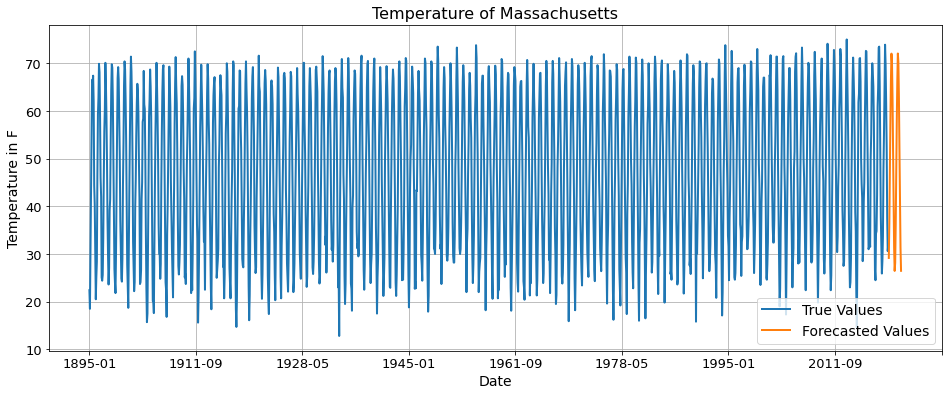

In [20]:
model = get_SARIMA_model(X, p, d, q, P, D, Q, s=season).fit(trend='nc')

X_preds = model.forecast(24)

plot_series(
    df.Value, X_preds, 
    title='Temperature of Massachusetts',
    y_label='Temperature in F', 
    forecast=True
)

**Congratulations** on completing this assignment on Temperature Forecast !!! We believe you've acquired a good basis of analysis ideas to work with seasonal data and fitting SARIMA models on such data.